In [1]:
import joblib
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.path as mpath
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from nltk.tokenize import TweetTokenizer


from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Sentiment extraction with Sentiment140

## Monthly Sentiment

In [3]:
df = pd.read_csv('Senpy/sentiment140/uber_support_sent140.csv') 
df['dateDay'] = pd.to_datetime(df['date']).dt.date
df_p = df.groupby(df['dateDay']).size().reset_index(name='Count')

In [4]:
df_ordered = df.sort_values(by='date',ascending=True).reset_index()
df_ordered

,index,cashtags,created_at,date,day,geo,hashtags,hour,id,language,...,tweet,urls,user_id,user_id_str,user_rt,user_rt_id,username,video,polarity140,dateDay
0,58286,[],1.577837e+12,2020-01-01 00:01:48,3.0,NaN,[],0.0,1.212162e+18,en,...,@Uber_Support Appreciate the reply but it's be...,[],7.790997e+08,7.790997e+08,NaN,NaN,The_Greggs_Man,0.0,marl:Neutral,2020-01-01
1,58285,[],1.577837e+12,2020-01-01 00:02:28,3.0,NaN,[],0.0,1.212162e+18,en,...,@Uber_Support @UberEats help,[],1.142132e+18,1.142132e+18,NaN,NaN,ToadShort,0.0,marl:Neutral,2020-01-01
2,58284,[],1.577837e+12,2020-01-01 00:02:44,3.0,NaN,[],0.0,1.212162e+18,en,...,@Uber_Support (2.1/2) First of all a comfortab...,[],5.630248e+08,5.630248e+08,NaN,NaN,Prash_Nagoorkar,0.0,marl:Positive,2020-01-01
3,58283,[],1.577837e+12,2020-01-01 00:09:05,3.0,NaN,[],0.0,1.212164e+18,en,...,@Snoooz95 @Mellijuana @AvrilsWritings @Uber_Su...,[],2.282730e+09,2.282730e+09,NaN,NaN,JECearlock,1.0,marl:Negative,2020-01-01
4,58282,[],1.577837e+12,2020-01-01 00:09:33,3.0,NaN,[],0.0,1.212164e+18,en,...,@Uber_Support @Uber was waiting 42 minutes for...,[],2.926998e+09,2.926998e+09,NaN,NaN,wonderkid100_92,0.0,marl:Negative,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215382,112025,[],1.609372e+12,2020-12-30 23:54:10,3.0,NaN,[],23.0,1.344432e+18,en,...,@Jadapmason @Uber_Support @mspairport @Uber Wo...,[],5.871576e+08,5.871576e+08,NaN,NaN,CourtneyWolff5,0.0,marl:Positive,2020-12-30
215383,112024,[],1.609372e+12,2020-12-30 23:54:14,3.0,NaN,[],23.0,1.344432e+18,en,...,@Uber_Support about to@hit an hour and a half ...,[],2.223367e+07,2.223367e+07,NaN,NaN,kersky24,0.0,marl:Negative,2020-12-30
215384,112023,[],1.609372e+12,2020-12-30 23:54:37,3.0,NaN,[],23.0,1.344432e+18,en,...,@Uber_Support I saw a charge on my bank statem...,[],9.662739e+08,9.662739e+08,NaN,NaN,hfry37,0.0,marl:Neutral,2020-12-30
215385,112022,[],1.609373e+12,2020-12-30 23:58:45,3.0,NaN,[],23.0,1.344433e+18,en,...,@Uber_Support I must have accidentally signed ...,[],1.266089e+18,1.266089e+18,NaN,NaN,areannagallant1,0.0,marl:Negative,2020-12-30


In [5]:
df_p.dateDay = pd.to_datetime(df_p.dateDay)
dm = df_p.groupby(pd.Grouper(key='dateDay', freq='1M')).sum() # groupby each 1 month
dm.index = dm.index.strftime('%B')
dm

,Count
dateDay,
January,22835
February,19704
March,15748
April,9950
May,12778
June,14524
July,16482
August,18479
September,17784


In [6]:
tweets_month = dm['Count'].tolist() # Tengo el numero de tweets diario
positive = [0 for _ in range(len(tweets_month))] # Month positive tweets
negative = [0 for _ in range(len(tweets_month))] # Month negative tweets
neutral = [0 for _ in range(len(tweets_month))] # Month neutral tweets
num_tweets_month = [0 for _ in range(len(tweets_month))] #Para comprobar

counter = 0
for i, value in enumerate(tweets_month):
    
    for pol in df_ordered['polarity140'][counter:counter+value]:
        if (pol == 'marl:Neutral'):
            neutral[i] = neutral[i] + 1
        if (pol == 'marl:Negative'):
            negative[i] = negative[i] + 1
        if (pol == 'marl:Positive'):
            positive[i] = positive[i] + 1
        num_tweets_month[i] = num_tweets_month[i] + 1
        
    counter = counter + value
    

In [7]:
total = [0 for _ in range(len(tweets_month))]
for i in range(len(tweets_month)):
    total[i] = positive[i] + negative[i] + neutral[i]
    
print(positive)
print(negative)
print(neutral)
print(total)
print(num_tweets_month)
print(dm)

[3329, 3078, 2210, 1383, 1750, 1900, 2250, 2444, 2231, 2594, 2696, 2952]
[8174, 6903, 5743, 3749, 4760, 5585, 6312, 7222, 7070, 8301, 9551, 9087]
[11332, 9723, 7795, 4818, 6268, 7039, 7920, 8813, 8483, 10349, 10790, 10783]
[22835, 19704, 15748, 9950, 12778, 14524, 16482, 18479, 17784, 21244, 23037, 22822]
[22835, 19704, 15748, 9950, 12778, 14524, 16482, 18479, 17784, 21244, 23037, 22822]
           Count
dateDay         
January    22835
February   19704
March      15748
April       9950
May        12778
June       14524
July       16482
August     18479
September  17784
October    21244
November   23037
December   22822


### Plot results

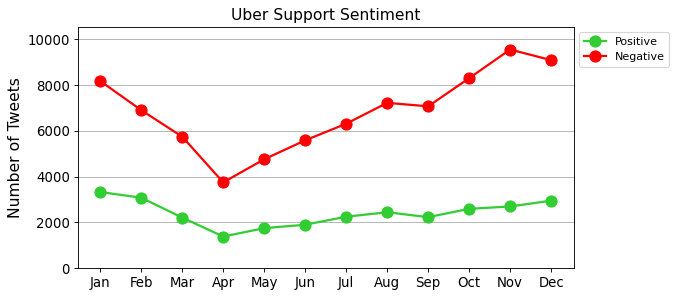

In [8]:
figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

circle = mpath.Path.unit_circle()
verts = np.concatenate([circle.vertices])
codes = np.concatenate([circle.codes])
cut_circle = mpath.Path(verts, codes)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(months, positive, 'limegreen', linewidth = 2 , marker=cut_circle, markersize=10, label = 'Positive')
plt.plot(months, negative, 'red', linewidth = 2 , marker=cut_circle, markersize=10, label = 'Negative')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.title('Uber Support Sentiment', fontsize = 14)
plt.ylim([0,max(negative) + 1000])
axes = plt.gca()
axes.yaxis.grid()
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [9]:
# Porcentajes
total = [0 for _ in range(len(tweets_month))]
pos_porc = [0 for _ in range(len(tweets_month))]
neg_porc = [0 for _ in range(len(tweets_month))]
diff = [0 for _ in range(len(tweets_month))]

for i in range(len(tweets_month)):
    total[i] = positive[i] + negative[i]
    pos_porc[i] = positive[i] / total[i]
    neg_porc[i] = negative[i] / total[i]
    diff[i] = negative[i] - positive[i]

print(pos_porc)
print(neg_porc)
print(diff)


[0.2894027644962184, 0.3083859332732191, 0.27788256004023637, 0.269485580670304, 0.26881720430107525, 0.25384101536406145, 0.26278906797477225, 0.25284502379474444, 0.23986668100204278, 0.23809086737035337, 0.2201355433983833, 0.24520308995763768]
[0.7105972355037816, 0.6916140667267808, 0.7221174399597636, 0.7305144193296961, 0.7311827956989247, 0.7461589846359385, 0.7372109320252278, 0.7471549762052555, 0.7601333189979572, 0.7619091326296467, 0.7798644566016167, 0.7547969100423623]
[4845, 3825, 3533, 2366, 3010, 3685, 4062, 4778, 4839, 5707, 6855, 6135]


## Sentiment per cluster

### Load matrix and cluster-centroids

In [10]:
matrix_np = joblib.load("matrix_np.pkl")

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
cluster_centers = [0.07090695, 0.05472499, 0.04853281, 0.57385279, 0.08962707, 0.08657469,
 0.07578069, 0.59317938, 0.06076465, 0.05862975, 0.07064416 ,0.06814184,
 0.04867284, 0.09996735, 0.06900363, 0.05984088 ,0.053046  , 0.0576334,
 0.07372197, 0.05189116, 0.63486295, 0.07800525 ,0.50455501 ,0.08606383,
 0.0680363 , 0.09070192, 0.08341853, 0.08921917 ,0.060258  , 0.08105422,
 0.09413673, 0.09088451, 0.07929615, 0.52263475 ,0.07173562 ,0.07688051,
 0.06956704, 0.06030905, 0.07134867, 0.57871554 ,0.0567995 , 0.08637969,
 0.08485652, 0.07823738, 0.53178314, 0.05498048 ,0.08116257, 0.09027348,
 0.07870644]



#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Group tweets from cluster

In [11]:
df_uber = pd.read_csv("Senpy/Sentiment140/uber_support_sent140.csv")

corpus = MmCorpus("corpus.corp")
texts = joblib.load('texts.pkl')
fulltexts = joblib.load('fulltexts.pkl')
model_list_6 = joblib.load('model_list_6.pkl')
lda_model = model_list_6[6]

df_uber['cleaned_texts_1'] = fulltexts
df_uber['length'] = df_uber['cleaned_texts_1'].str.len()
df_uber = df_uber[df_uber['length'] > 0] 
df_uber['cleaned_texts'] = texts
df_analyse = df_uber[['date','tweet', 'cleaned_texts_1', 'cleaned_texts', 'length', 'polarity140']].reset_index()
df = df_analyse

def tokenizeTweets (words):
    tokens = []
    #print(words)
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(words)
    tokens = [w.lower() for w in tokens] 
    return tokens

texts = [tokenizeTweets(document) for document in df_analyse['tweet']]

#df['maximum_probability'] = df2   
df['date'] = df_analyse['date']
df['tweet'] = df_analyse['tweet']
df['tweet_tokenized'] = texts
df['cleaned_texts'] = df_analyse['cleaned_texts']
df['cleaned_texts_1'] = df_analyse['cleaned_texts_1']
df['length'] = df['tweet_tokenized'].str.len()
df['length_cleaned'] = df_analyse ['length']

In [12]:
def topicAssignament(documents, dimensions, number_topics):
    
    labels = []
    counter_docs = [0 for x in range(0,number_topics)]
        
    for document in documents: 
        distance_to_cluster = []   
        counter = 0
        for dim in range(0,number_topics): 
            distance_to_cluster.append(np.linalg.norm(document-dimensions[counter:counter+7]))
            counter = counter + 7
            
        best_distance_index = distance_to_cluster.index(min(distance_to_cluster)) 
        
        counter_docs[best_distance_index] += 1
    
        labels.append(best_distance_index)
     
    return labels, counter_docs

labels, counter_docs = topicAssignament(matrix_np, cluster_centers, 7)
print(len(labels))
df['topic'] = labels
df.head(10) # AQUI YA TENGO CADA DOCUMENTO/TOPIC

212400


,index,date,tweet,cleaned_texts_1,cleaned_texts,length,polarity140,tweet_tokenized,length_cleaned,topic
0,0,2020-03-31 23:58:31,@LauraKellyKS @KansasGOP why did @Uber_Support...,"[follow, promis, disinfect, materi, driver, ca...","[follow, promis, disinfect, materi, driver, ca...",47,marl:Neutral,"[@laurakellyks, @kansasgop, why, did, @uber_su...",47,3
1,1,2020-03-31 23:52:51,@Uber_Support why did @Uber_Support and uber ...,"[uber, follow, thru, promis, disinfect, materi...","[uber, follow, thru, promis, disinfect, materi...",49,marl:Neutral,"[@uber_support, why, did, @uber_support, and, ...",49,3
2,2,2020-03-31 23:51:11,why did @Uber_Support @Uber not follow thru wi...,"[follow, promis, disinfect, materi, driver, ca...","[follow, promis, disinfect, materi, driver, ca...",47,marl:Neutral,"[why, did, @uber_support, @uber, not, follow, ...",47,3
3,3,2020-03-31 23:50:58,Same song and dance @Uber @Uber_Support @dkhos...,"[song, danc, dead, wrong, handl, pandem, pligh...","[song, danc, dead, wrong, handl, pandem, pligh...",31,marl:Neutral,"[same, song, and, dance, @uber, @uber_support,...",31,2
4,4,2020-03-31 23:46:27,"@Uber_Support Hey, I'm receiving ride reports ...","[receiv, ride, report, email, even, account, guy]","[receiv, ride, report, email, even, account, guy]",21,marl:Neutral,"[@uber_support, hey, ,, i'm, receiving, ride, ...",21,2
5,6,2020-03-31 23:33:37,@Uber_Support Uber gives me a ride request the...,"[uber, give, ride, request, app, right, away]","[uber, give, ride, request, app, right, away]",20,marl:Neutral,"[@uber_support, uber, gives, me, a, ride, requ...",20,6
6,7,2020-03-31 23:28:49,@Uber_Support No way. I’m not worried about my...,"[way, worri, privaci, say, continu, work, supp...","[way, worri, privaci, say, continu, work, supp...",45,marl:Negative,"[@uber_support, no, way, ., i, ’, m, not, worr...",45,5
7,8,2020-03-31 23:28:13,@Uber_Support I'm trying to file for my Califo...,"[tri, file, california, state, unemploy, insur...","[tri, file, california, state, unemploy, insur...",59,marl:Negative,"[@uber_support, i'm, trying, to, file, for, my...",59,3
8,9,2020-03-31 23:27:48,@Uber_Support Please @Uber_Support answer me i...,"[answer, messag, box]","[answer, messag, box]",8,marl:Neutral,"[@uber_support, please, @uber_support, answer,...",8,2
9,10,2020-03-31 23:21:43,@Uber_Support Why is there no contact info? Ho...,"[contact, info, avoid, charg, driver, say, bus...","[contact, info, avoid, charg, driver, say, bus...",22,marl:Negative,"[@uber_support, why, is, there, no, contact, i...",22,4


### Count polarity

In [13]:
# Guardamos la polaridad de cada topic
#counter_docs
positive = [0 for _ in range(7)]
negative = [0 for _ in range(7)]
neutral = [0 for _ in range(7)]

df0 = df.loc[df['topic'] == 0]
df1 = df.loc[df['topic'] == 1]
df2 = df.loc[df['topic'] == 2]
df3 = df.loc[df['topic'] == 3]
df4 = df.loc[df['topic'] == 4]
df5 = df.loc[df['topic'] == 5]
df6 = df.loc[df['topic'] == 6]


for pol in df0['polarity140']:
    i = 0
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1
        
for pol in df1['polarity140']:
    i = 1
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1
              
for pol in df2['polarity140']:
    i = 2
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1
         
for pol in df3['polarity140']:
    i = 3
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1
        
        
for pol in df4['polarity140']:
    i = 4
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1       
        
for pol in df5['polarity140']:
    i = 5
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1

for pol in df6['polarity140']:
    i = 6
    if (pol == 'marl:Neutral'):
        neutral[i] = neutral[i] + 1
    if (pol == 'marl:Negative'):
        negative[i] = negative[i] + 1
    if (pol == 'marl:Positive'):
        positive[i] = positive[i] + 1


In [14]:
positive_percentaje = [0 for _ in range(7)]
negative_percentaje = [0 for _ in range(7)]
neutral_percentaje = [0 for _ in range(7)]
# Calculamos el % de negativo y positivo

for i, total in enumerate(counter_docs):
    positive_percentaje[i] = positive[i] / total
    negative_percentaje[i] = negative[i] / total
    neutral_percentaje[i] = neutral[i] / total
    
print(positive_percentaje)
print(negative_percentaje)
print(neutral_percentaje)



[0.08792425457183217, 0.07957674576900467, 0.17035821096894604, 0.19838112698467605, 0.11018041237113402, 0.1347238189084141, 0.1251573458011149]
[0.5195662963387164, 0.48466940998112684, 0.2918306311978593, 0.27987823861081323, 0.4585787923416789, 0.3806864838232879, 0.3686387340406402]
[0.3925094490894514, 0.4357538442498685, 0.5378111578331947, 0.5217406344045107, 0.43124079528718706, 0.48458969726829804, 0.5062039201582449]


### Plot results

#### Radar plot

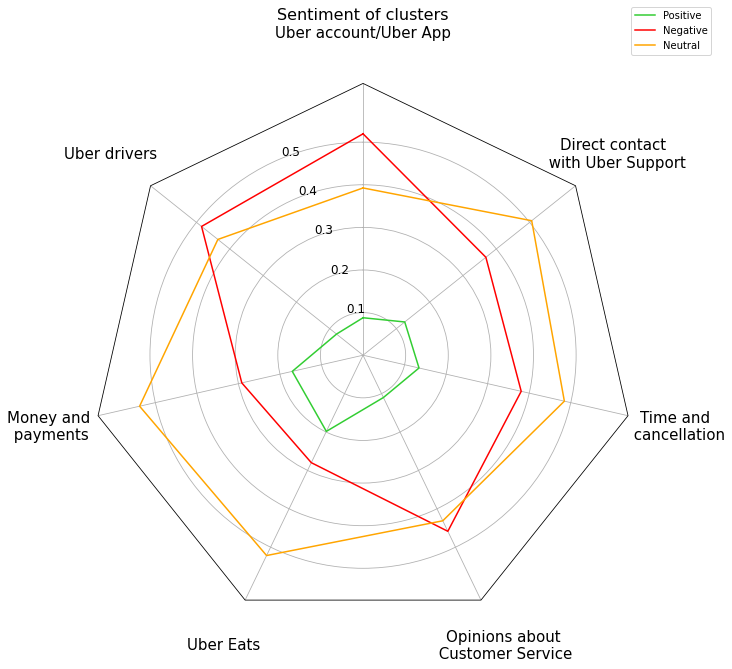

In [15]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta




data = [['Uber account/Uber App', 'Uber drivers', 'Money and\n payments', 'Uber Eats', 'Opinions about\n Customer Service',
         'Time and \n cancellation', 'Direct contact \n with Uber Support'],
        ('Sentiment of clusters', [
           positive_percentaje,
           negative_percentaje,
           neutral_percentaje

        ])]

lab = ['Positive', 'Negative', 'Neutral']

N = len(data[0])
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)

title, case_data = data[0]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))

#fig.subplots_adjust(top=0.95, bottom=0.05)

ax.set_rgrids([0.1 ,0.2, 0.3, 0.4, 0.5])
ax.set_title(title,  position=(0.5, 1.1), ha='center', fontsize = 16)

colors = ['limegreen', 'red', 'orange']

for d, color, label in zip(case_data, colors, lab):
    line = ax.plot(theta, d, color = color, label = label)
    ax.set_ylim([0, max(d) + 0.1])
    #ax.fill(theta, d,  alpha=0.25)

ax.set_varlabels(spoke_labels)

# Modificas los porcentajes 0.1, 0.2 ..... 
ax.tick_params(axis='y', labelsize=12)

# Con esto MODIFICAS lOS TOPICS tamaño y DISTANCIA
ax.tick_params(axis='x', labelsize=15, direction="out", pad=40)

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))

plt.show()

#### Pie chart global sentiment

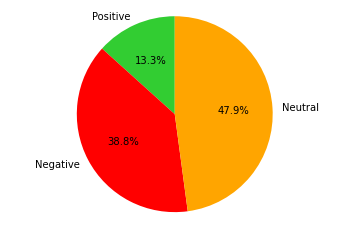

In [16]:
sizes = []
sum_positives = sum(np.array(positive))
sizes.append(sum_positives)
sum_negative = sum(np.array(negative))
sizes.append(sum_negative)
sum_neutral = sum(np.array(neutral))
sizes.append(sum_neutral)


labels = ['Positive', 'Negative', 'Neutral']
colors = ['limegreen', 'red', 'orange']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.savefig('./barChart/LDA6/pie.jpg', dpi=1000)
plt.show()

#### Bar plot

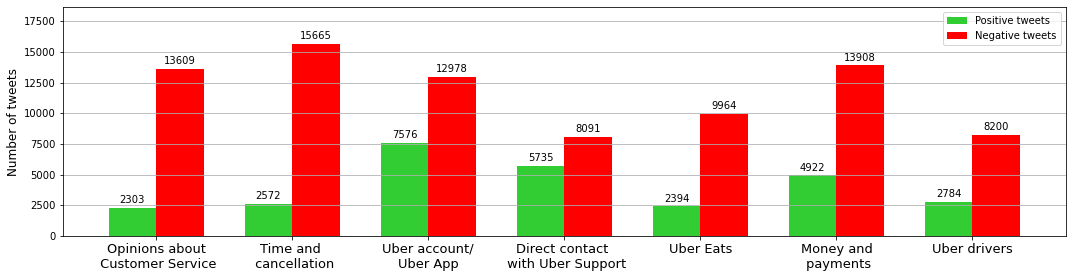

In [17]:
labels = ['Opinions about\n Customer Service', 'Time and \n cancellation', 'Uber account/\nUber App', 'Direct contact \n with Uber Support', 'Uber Eats','Money and\n payments' ,
         'Uber drivers']

positives = positive
negatives = negative

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 4))
rects1 = ax.bar(x - width/2, positives, width, label='Positive tweets', color= 'limegreen')
rects2 = ax.bar(x + width/2, negatives, width, label='Negative tweets', color= 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_xlabel('Topics', fontsize = 12)
ax.set_ylabel('Number of tweets', fontsize = 12)

#ax.set_title('Sentiment associated to cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 13)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.ylim([0,max(negative)+3000])

axes = plt.gca()
axes.yaxis.grid()
plt.legend(bbox_to_anchor = (1, 1))

plt.show()